# GLMM 負の二項分布回帰

ポアソン分布が過分散のときに使用できる分布が負の二項分布であり，ポアソン回帰が過剰に精密に推定してしまうことを防ぐために使用される．

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpboost as gpb
from patsy import dmatrix

In [2]:
filepath = '../../../../../../data/processed/df_filtered_5years.xlsx'
df = pd.read_excel(filepath).drop(columns='special')
df = df.dropna()
df.head()

,island,year,island_id,region_code,region_name,prefecture_code,population,dummy_island_has_bridge,dummy_island_is_connected_mainland,year_bridge_opened,dummy_after_bridge_opened,year_connect_mainland,dummy_after_connect_mainland,income,prefecture_name,area_km2,distance_m
5,島後,2005,62,32528,隠岐の島町,32,17259.0,0.0,0.0,0.0,0.0,0.0,0.0,2030.888121,島根県,241.53,67840.0
6,島後,2010,62,32528,隠岐の島町,32,15930.0,0.0,0.0,0.0,0.0,0.0,0.0,1725.990958,島根県,241.53,67840.0
7,島後,2015,62,32528,隠岐の島町,32,14901.0,0.0,0.0,0.0,0.0,0.0,0.0,1613.531700,島根県,241.53,67840.0
8,島後,2020,62,32528,隠岐の島町,32,13882.0,0.0,0.0,0.0,0.0,0.0,0.0,1686.173400,島根県,241.53,67840.0
10,中ノ島,1985,63,32525,海士町,32,3339.0,0.0,0.0,0.0,0.0,0.0,0.0,363.212405,島根県,32.29,49730.0


## Define the variables

In [3]:
population = df['population']
bridge = df['dummy_after_bridge_opened']
income = df['income']
log_income = np.log(income)
area = df['area_km2']
log_area = np.log(area)
distance = df['distance_m']
log_distance = np.log(distance)

# 過分散パラメータ
mean_population = np.mean(population)
var_population = np.var(population)

alpha = (var_population - mean_population) / mean_population**2

## モデリング

### ランダム効果は島のみ

In [7]:
group = df['island_id']
y = df['population']
X = dmatrix('bridge + log_income + log_area + log_distance', data=df, return_type='dataframe')

model = gpb.GPModel(group_data=group, likelihood='negative_binomial') # 負の二項分布
model.fit(y=y, X=X, params={'std_dev': True})

pred = model.predict(X_pred=X, group_data_pred=group)['mu']
residuals = y - pred

print(model.summary())

Model summary:
 Log-lik      AIC      BIC
-5104.62 10221.23 10249.56
Nb. observations: 830
Nb. groups: 151 (island_id)
-----------------------------------------------------
Covariance parameters (random effects):
           Param.
island_id  1.5226
-----------------------------------------------------
Linear regression coefficients (fixed effects):
              Param.  Std. dev.  z value  P(>|z|)
Intercept     6.8190     0.5053  13.4951   0.0000
bridge       -0.0962     0.0890  -1.0816   0.2794
log_income   -0.0848     0.0122  -6.9376   0.0000
log_area      1.1243     0.0613  18.3522   0.0000
log_distance -0.2000     0.0681  -2.9364   0.0033
-----------------------------------------------------
Additional parameters:
        Param.
shape  11.2036


### ランダム効果は島と年

In [8]:
group = df[['island_id', 'year']]
y = df['population']
X = dmatrix('bridge + log_income + log_area + log_distance', data=df, return_type='dataframe')

model = gpb.GPModel(group_data=group, likelihood='negative_binomial') # 負の二項分布
model.fit(y=y, X=X, params={'std_dev': True})

pred = model.predict(X_pred=X, group_data_pred=group)['mu']
residuals = y - pred

print(model.summary())

Model summary:
 Log-lik     AIC     BIC
-4763.16 9540.32 9573.37
Nb. observations: 830
Nb. groups: 151 (island_id), 8 (year)
-----------------------------------------------------
Covariance parameters (random effects):
           Param.
island_id  1.7062
year       0.0616
-----------------------------------------------------
Linear regression coefficients (fixed effects):
              Param.  Std. dev.  z value  P(>|z|)
Intercept     5.5030     0.5231  10.5202   0.0000
bridge        0.0697     0.0513   1.3592   0.1741
log_income    0.0028     0.0079   0.3523   0.7246
log_area      1.3311     0.0589  22.6161   0.0000
log_distance -0.1461     0.0703  -2.0786   0.0377
-----------------------------------------------------
Additional parameters:
        Param.
shape  40.7343


## 残差分析

In [23]:
# 変数と残差の相関
corr_log_income = np.corrcoef(df['log_income'], residuals)[0, 1]
corr_bridge = np.corrcoef(df['dummy_after_bridge_opened'], residuals)[0, 1]
coor_population = np.corrcoef(df['population'], residuals)[0, 1]

print(f'coor between log_income and residuals: {corr_log_income:.3f}')
print(f'coor between bridge and residuals: {corr_bridge:.3f}')
print(f'coor between population and residuals: {coor_population:.3f}')

coor between log_income and residuals: 0.037
coor between bridge and residuals: -0.030
coor between population and residuals: -0.010


### 残差プロット

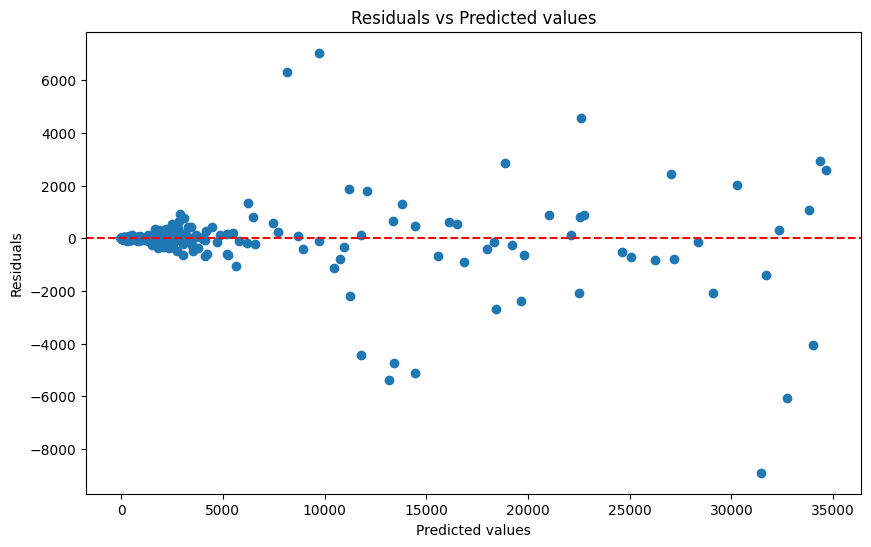

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(pred, residuals)
plt.axhline(0, color='red', ls='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.show()

### 残差ヒストグラム

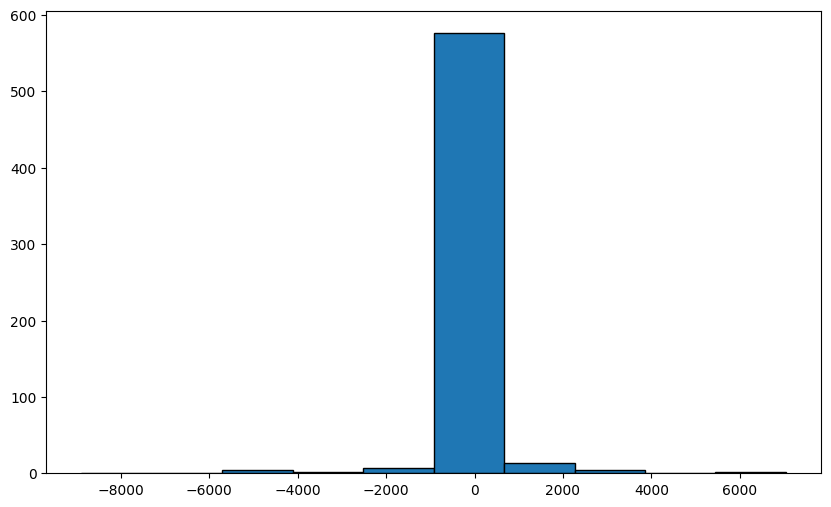

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, edgecolor='black')
plt.show()